# Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/SIAP/dataset/clean

/content/drive/MyDrive/SIAP/dataset/clean


# Imports


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

# Data Frame

In [ ]:
df_train = pd.read_csv('train_clean_removed_emoticons.csv')

X_train = df_train['Review Text']
y_train = df_train['Rating']

# Lematization

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
#ps = LancasterStemmer()
ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
# Removing unessessary words that have no meaning (concluded experimentally)
stop_words.add('dress')
stop_words.add('petite')
stop_words.add('jacket')
stop_words.add('blazer')

def remove_stopwords(data):
    output_array=[]
    for sentence in data:
        temp_list=[]
        for word in sentence.split():
            if word.lower() not in stop_words:
                temp_list.append(word)
        output_array.append(' '.join(temp_list))
    return output_array

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    # words = [w for w in words if not w in stop_words] #3
    words = [lemmatizer.lemmatize(w) for w in words] #3.1
    words = remove_stopwords(words)
    #words = [ps.stem(w) for w in words] #4 steming acctualy gives worse results when added #4
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Data cleaning 

In [ ]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df_train['Cleaned_Review_Text'] = df_train['Review Text'].apply(clean_text)

# df_train['Cleaned_Review_Text']

In [ ]:
new_str_train = [str(x) for x in df_train['Cleaned_Review_Text']]

df_train_review_text = pd.DataFrame(new_str_train)

sent = []
for i in range(len(df_train_review_text)):
  sent.append(preprocessing(df_train_review_text.iloc[i]))

# word2vec using gensim library

In [ ]:
# size:       The number of dimensions of the embeddings and the default is 100.
# window:     The maximum distance between a target word and words around the target word. The default window is 5.
# min_count:  The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.
# workers:    The number of partitions during training and the default workers is 3.
# sg:         The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW. 
 
from gensim.models import Word2Vec
model = Word2Vec(sent, min_count=1,size= 50,workers=3, window =3, sg = 1)

In [ ]:
model.most_similar('nice')[:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('great', 0.8727607727050781),
 ('awesome', 0.869699239730835),
 ('draping', 0.8525125980377197),
 ('good', 0.8522183895111084),
 ('floaty', 0.8348839282989502)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 

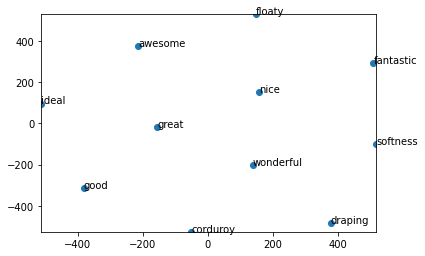

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]

    close_words = model.similar_by_word(word)

    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

display_closestwords_tsnescatterplot(model, 'nice', 50)